# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

#### Algorithm Author: Jason Chen
#### Overall Success Rate on Test Set: 61.1%

## Content
* Instruction
* Data Analysis: Relationship Between Words and Vowels
* HangmanAPI and Algorithm
* Playing practice games
* Playing recorded games

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server.

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [1]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections
try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\User\AppData\Local\Temp\ipykernel_14920\895811027.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data Analysis: Relationship Between Words and Vowels
Based on the analysis, the following results were obtained:
* Nearly every word contains at least one vowel.
* Among these vowels, the most frequently occurring are in the order of e, i, a, o, and u.
* As illustrated in the plot below, the majority of words consist of 20% to 55% vowels relative to their length.

These findings imply that we can:
* Predict vowels at the beginning.
* Predict vowels based on the order of frequency: e, i, a, o, u.
* Given a word, continue predicting vowels until the proportion reaches over 20%.
* Given a word, refrain from predicting additional vowels once the proportion exceeds 50%.

In [20]:
vowels = ['a', 'e', 'i', 'o', 'u']

In [16]:
data_path = r'C:\Users\User\Desktop\Programming\words_250000_train.txt'
df = pd.read_csv(data_path, names=['word'])
display(df.head())
data = df.values.flatten()

,word
0,aaa
1,aaaaaa
2,aaas
3,aachen
4,aaee


In [17]:
data

array(['aaa', 'aaaaaa', 'aaas', ..., 'zyzzyva', 'zz', 'zzz'], dtype=object)

In [18]:
print(data.shape)

(227300,)


In [21]:
# Check whether every word contains at least one vowel
def check_contain_vowel(word):
    for letter in str(word):
        if letter in vowels:
            return 1
    print(word)
    return 0

result_arr = []
for d in data:
    result_arr.append(check_contain_vowel(d))
np.unique(result_arr, return_counts=True)

bb
bbb
bbl
bbn
bbxrt
bcbs
bcd
bcf
bchs
bcm
bcpl
bcs
bcws
bdd
bdf
bdl
bdls
bds
bdt
bfd
bfhd
bfr
bft
bgp
bhc
bht
bkbndr
bkg
bklr
bkpt
bkt
bldg
bldr
blk
bll
blt
blv
bly
blyth
bmj
bmr
bmt
bmv
bn
bnfl
bnsc
bps
bpt
brc
brcs
brg
brm
brrr
brt
brynn
bsc
bsch
bscp
bsf
bsfmgt
bsft
bsgmgt
bsh
bshyg
bsj
bsl
bsls
bsmtp
bsn
bsp
bsphn
bspt
bsrt
bst
bstj
bsw
btl
btry
bv
bvc
bvds
bvm
bvy
bwc
bwr
bwts
bx
by
byrd
byrls
bys
byss
byz
bz
c
cbc
cbds
cbr
cbw
cc
ccccm
ccd
ccf
cckw
ccls
ccnc
ccr
ccs
cct
ccv
ccws
cdb
cdcf
cdg
cdn
cdpr
cds
cdt
cf
cfb
cfh
cfm
cfp
cfs
cgn
cgx
chn
chq
chrys
chym
ck
cl
cldn
clk
cllr
clr
cls
clwyd
clywd
cmc
cmd
cmdg
cmds
cmg
cmh
cml
cms
cmt
cmyk
cncc
cnms
cnr
cnsr
cph
cpm
cpr
cpsr
cpt
cpw
cr
crc
crd
crfc
crl
crp
crtc
crwth
cry
crypt
crypts
csb
csch
csd
csf
csk
csm
csmp
csrg
csrs
cst
cstc
csw
ctd
ctg
ctms
ctr
cts
ctt
cttn
cv
cvcc
cvt
cwm
cwms
cwt
cy
cyb
cyc
cyd
cyl
cymry
cyn
cyndy
cynth
cynwyd
cyp
cyt
cywydd
d
dbf
dbm
dbmm
dbrn
dbv
dc
dcb
dcc
dccs
dcl
dcmg
dcnl
dcpr
dcs
dctn
ddb
ddcmp
d

(array([0, 1]), array([  1249, 226051], dtype=int64))

In [35]:
print("There are %.5f of words don't conatain any vowels" % (1249/226051))
# Therefore, it's reasonable to guess vowels at the beginning of words.

There are 0.00553 of words don't conatain any vowel


In [23]:
# Calculate the number of words that contain vowels
def check_whether_contain_key(word, key):
    if(str(key) in str(word)):
        return 1
    return 0


word_cnt_have_vowel = []

vowels = ['a', 'e', 'i', 'o', 'u']
for vowel in vowels:
    cnt = 0
    for d in data:
        cnt += check_whether_contain_key(d, vowel)
    word_cnt_have_vowel.append(cnt)

print(word_cnt_have_vowel)
# ['e', 'i', 'a', 'o', 'u']

[133660, 154827, 134627, 111416, 67622]


In [31]:
def vowel_to_len_ratio(clean_word):
    '''
    Given a clean_word, return the ratio of the count of vowels to the length of the word.
    '''
    count = 0
    vowels = ['a', 'e', 'i', 'o', 'u']
    for i in str(clean_word):
        if i in vowels:
            count += 1.0
    return count / len(str(clean_word))

In [32]:
# Get the vowel-to-length ratio of all words
vowel_to_len_ratio_list = []
for word in df['word']:
    vowel_to_len_ratio_list.append(vowel_to_len_ratio(word))

# Convert to Series to get statistical information
vowel_to_len_ratio_df = pd.Series(vowel_to_len_ratio_list)
vowel_to_len_ratio_df.describe()

count    227300.000000
mean          0.386889
std           0.095527
min           0.000000
25%           0.333333
50%           0.384615
75%           0.444444
max           1.000000
dtype: float64

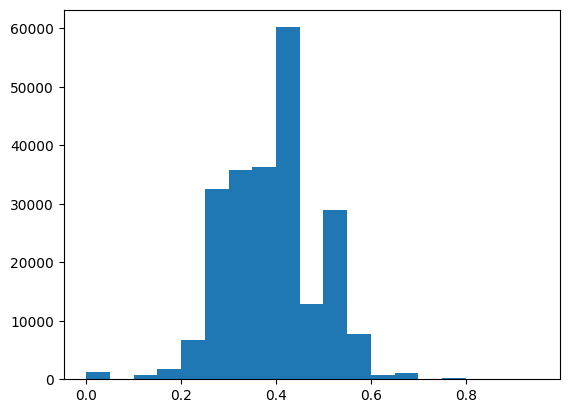

In [34]:
bins = np.arange(0.0, 1.0, 0.05)
plt.hist(x = vowel_to_len_ratio_df, bins=bins);
# Most words contain 20% - 55% vowels

## HangmanAPI and Algorithm

In [5]:
HANGMAN_URL = "https://www.trexsim.com/trexsim/hangman"

class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)        
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        
        self.current_dictionary = []
        
        self.range = 0
        self.all_word_dictionary = self.generate_all_word_dict()
    

    def vowel_to_len_ratio(self, clean_word:str) -> float:
        '''
        Given a clean_word, return the ratio of the count of vowels to the length of the word.
        '''
        count = 0
        vowels = ['a', 'e', 'i', 'o', 'u']
        for i in clean_word:
            if i in vowels:
                count += 1.0
        return count / len(clean_word)


    def generate_all_word_dict(self) -> collections.defaultdict:
        '''
        Generate words of different lengths from the full_dictionary and store them based on their length.
        
        Output: 
        * defaultdict(list), The key represents the word length, and the corresponding value is a list.
        '''
        # Get max length of word in self.full_dictionary
        max_length = 0
        for words in self.full_dictionary:
            if(len(words) > max_length):
                max_length = len(words)
        
        # Generate words of different lengths
        all_word_dictionary = collections.defaultdict(list)
        cnt = 3
        while cnt <= max_length:
            for word in self.full_dictionary:
                if(len(word) >= cnt):
                    for i in range(len(word) - cnt + 1): 
                        all_word_dictionary[cnt].append(word[i:i + cnt]) 
            cnt += 1

        return all_word_dictionary


    def letter_in_each_word_cnt(self, new_dictionary:list[str]) -> collections.Counter:
        '''
        Check whether a letter exists in each word from the new_dictionary and sum up the occurrences.
        Note: In a word, each letter's occurrence counts as 1, regardless of its frequency.
        
        Input: 
        * new_dictionary, a list of words

        Output: 
        * total_word_counter, Counter, The key represents a letter, and the corresponding value is its occurrence count in a dictionary.
        '''
        total_word_counter = collections.Counter()
        for word in new_dictionary:
            word_counter = collections.Counter(str(word))    #
            delete_letter = []    # For deleting already guessed letters
            for key in word_counter:
                if str(key) in self.guessed_letters:
                    delete_letter.append(key)
                else:
                    word_counter[key] = 1    # In a word, each letter's occurrence counts as 1, regardless of its frequency.
            
            for key in delete_letter:
                del word_counter[key]
            total_word_counter += word_counter
            
        return total_word_counter


    def get_new_dictionary_acccord_pattern(self, pattern:str, old_dictionary:list[str]) -> list[str]:
        '''
        Generate a new dictionary from the old dictionary containing words that match the specified pattern.
        
        Notes:
        * A word eligible for inclusion in the new dictionary cannot contain any incorrectly guessed letters.
        * Additionally, it must have the same number of correctly guessed letters.
        
        Inputs:
        * pattern: str
        * old_dictionary: list of words

        Outputs:
        * new_dictionary: list of words
        '''
        # Retrieve the incorrectly guessed letters
        wrong_guessed_letter_list = []
        for letter in self.guessed_letters:
            if letter not in pattern:
                wrong_guessed_letter_list.append(letter)
        
        new_dictionary = []
        clean_word_counter = collections.Counter(pattern)
        
        for dict_word in old_dictionary:
            # A word eligible for inclusion in the new dictionary cannot contain any incorrectly guessed letters
            contain_wrong_guessed_letter_flag = False
            for letter in wrong_guessed_letter_list:
                if letter in dict_word:
                    contain_wrong_guessed_letter_flag = True
                    break
            
            if contain_wrong_guessed_letter_flag == False and re.match(pattern, dict_word):
                # it must have the same number of correctly guessed letters
                equal_amount_flag = True
                dict_word_counter = collections.Counter(dict_word)
                for key, value in clean_word_counter.items():
                    if key == '.':
                        continue
                    if dict_word_counter[key] != value:
                        equal_amount_flag = False
                        break
                if equal_amount_flag:
                    new_dictionary.append(dict_word)
        return new_dictionary


    def guess(self, word): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################

        # clean the word so that we strip away the space characters
        # replace "_" with "." as "." indicates any character in regular expressions
        clean_word = word[::2].replace("_",".")
        
        guess_letter = '!'
        
        # At the very beginning, guess vowels
        vowels = ['e', 'i', 'a', 'o', 'u']
        if self.vowel_to_len_ratio(clean_word) < 0.2:
            for vowel in vowels:
                if vowel not in self.guessed_letters:
                    guess_letter = vowel
                    return guess_letter
    
        # Retrieve words that match the clean_word (across the entire length), 
        # Count the occurrence of each letter in every word from the all_word_dictionary, 
        # Identify the most frequently occurring letter, 
        # And then guess it.
        if self.range == len(clean_word) and guess_letter == '!':
            self.current_dictionary = self.get_new_dictionary_acccord_pattern(clean_word, self.current_dictionary)
            cnter = self.letter_in_each_word_cnt(self.current_dictionary)
            sorted_letter_cnt = cnter.most_common()
            for letter,instance_count in sorted_letter_cnt:
                if letter not in self.guessed_letters:
                    if letter in vowels and self.vowel_to_len_ratio(clean_word) > 0.55:                  
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    return guess_letter
            self.range = int(len(clean_word) / 2)
        

        # Retrieve words that match the clean_word (within half of its length), 
        # Count the occurrence of each letter in every word from the all_word_dictionary, 
        # Identify the most frequently occurring letter, 
        # And then guess it.
        if self.range == int(len(clean_word) / 2) and self.range >= 3 and guess_letter == '!':
            cnter = collections.Counter()
            for i in range(len(clean_word) - self.range+1):
                new_pattern = clean_word[i:i + self.range]
                self.current_dictionary = self.get_new_dictionary_acccord_pattern(new_pattern, self.all_word_dictionary[self.range])
                temp = self.letter_in_each_word_cnt(self.current_dictionary)
                cnter += temp
            sorted_letter_cnt = cnter.most_common()
            for letter, instance_count in sorted_letter_cnt:
                if letter not in self.guessed_letters:
                    if letter in vowels and self.vowel_to_len_ratio(clean_word) > 0.55:                  
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    return guess_letter

            self.range = int(len(clean_word) / 3)
        
        
        # Retrieve words that match the clean_word (within one-third of its length), 
        # Count the occurrence of each letter in every word from the all_word_dictionary, 
        # Identify the most frequently occurring letter, 
        # And then guess it.
        if self.range == int(len(clean_word) / 3) and self.range >= 3 and guess_letter == '!':
            cnter = collections.Counter()
            for i in range(len(clean_word) - self.range + 1):
                new_pattern = clean_word[i:i + self.range]
                self.current_dictionary = self.get_new_dictionary_acccord_pattern(new_pattern, self.all_word_dictionary[self.range])
                temp = self.letter_in_each_word_cnt(self.current_dictionary)
                cnter += temp
            sorted_letter_cnt = cnter.most_common()
            for letter, instance_count in sorted_letter_cnt:
                if letter not in self.guessed_letters:
                    if letter in vowels and self.vowel_to_len_ratio(clean_word) > 0.55:                  
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    return guess_letter
        
            
        # if no word matches in training dictionary, default back to ordering of full dictionary
        if guess_letter == '!':
            sorted_letter_count = self.full_dictionary_common_letter_sorted
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in vowels and self.vowel_to_len_ratio(clean_word) > 0.55:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break            
        
        return guess_letter

    

    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            
            # New
            self.range = len(word) / 2
            self.current_dictionary = self.all_word_dictionary[self.range]

            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        try:
            # response = self.session.request(
            response = requests.request(
                method or "GET",
                HANGMAN_URL + path,
                timeout=self.timeout,
                params=args,
                data=post_args)
        except requests.HTTPError as e:
            response = json.loads(e.read())
            raise HangmanAPIError(response)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [6]:
api = HangmanAPI(access_token="31da3b5fbac8a71175c2ef556c7cb6", timeout=2000)


## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [7]:
times = 30
[prev_total_practice_runs,total_recorded_runs,total_recorded_successes,prev_total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)

for i in range(times):
    api.start_game(practice=1,verbose=True)

[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status()
practice_success_rate = (total_practice_successes - prev_total_practice_successes) / (total_practice_runs - prev_total_practice_runs)
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs - prev_total_practice_runs, practice_success_rate))


Successfully start a new game! Game ID: d8923d170c96. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': 'd8923d170c96', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ _ _ _ _ e '}
Guessing letter: i
Sever response: {'game_id': 'd8923d170c96', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ i _ _ _ e _ _ _ _ _ e '}
Guessing letter: l
Sever response: {'game_id': 'd8923d170c96', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ i _ _ l e _ _ _ _ l e '}
Guessing letter: a
Sever response: {'game_id': 'd8923d170c96', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ i _ _ l e _ a _ _ l e '}
Guessing letter: g
Sever response: {'game_id': 'd8923d170c96', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i _ _ l e _ a _ _ l e '}
Guessing letter: b
Sever response: {'game_id': 'd8923d170c96', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ i _ _ l e _ a _ _ l e '}
Guessing letter: f
Sever response: {'game_id': 'd

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [8]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Playing  1  th game
Playing  2  th game
Playing  3  th game
Playing  4  th game
Playing  5  th game
Playing  6  th game
Playing  7  th game
Playing  8  th game
Playing  9  th game
Playing  10  th game
Playing  11  th game
Playing  12  th game
Playing  13  th game
Playing  14  th game
Playing  15  th game
Playing  16  th game
Playing  17  th game
Playing  18  th game
Playing  19  th game
Playing  20  th game
Playing  21  th game
Playing  22  th game
Playing  23  th game
Playing  24  th game
Playing  25  th game
Playing  26  th game
Playing  27  th game
Playing  28  th game
Playing  29  th game
Playing  30  th game
Playing  31  th game
Playing  32  th game
Playing  33  th game
Playing  34  th game
Playing  35  th game
Playing  36  th game
Playing  37  th game
Playing  38  th game
Playing  39  th game
Playing  40  th game
Playing  41  th game
Playing  42  th game
Playing  43  th game
Playing  44  th game
Playing  45  th game
Playing  46  th game
Playing  47  th game
Pl

HangmanAPIError: {'error': 'You have reached 1000 of games', 'status': 'denied'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [9]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.611
